In [4]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_26968/1319117283.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create Gaussian blurs with varying widths and occluding bars

In [5]:
n_gauss     = 1000 # Total 2000 images
img_size    = 91

x    = np.linspace(start=-4, stop=4, num=img_size)
X, Y = np.meshgrid(x, x)

# Vary the weight smoothly
widths = np.linspace(start=2, stop=20, num=n_gauss)

# Initialize tensors containing images
images = torch.zeros(n_gauss, 1, img_size, img_size)

for i in range(n_gauss):
    
    # Create the gaussian with random centers
    # Ro = random offset
    # `i % 2`: Even image belong to label 0
    ro = 1.5 * np.random.randn(2)
    G  = np.exp(-((X - ro[0]) ** 2 + (Y - ro[1]) ** 2) / widths[i])
    
    # And add noise
    G += np.random.randn(img_size, img_size) / 5
    
    # Add a random bar randomly
    i1 = np.random.choice(np.arange(2, 28))
    i2 = np.random.choice(np.arange(2, 6))
    
    if np.random.randn() > 0:
        G[i1:i1 + i2, :] = 1
    else:
        G[:, i1:i1 + i2] = 1
    
    # Add to the tensor
    # `.view`: Convert from numpy matrix to PTorch Tensor
    images[i, :, :, :] = torch.tensor(G).view(1, img_size, img_size)

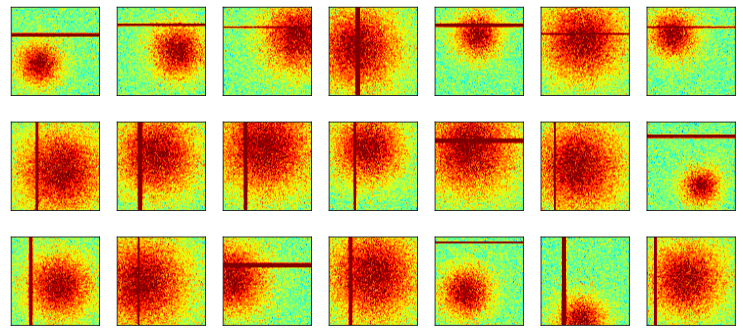

In [6]:
# Visualize some images
fig, axs = plt.subplots(3, 7, figsize=(13, 6))

for i, ax in enumerate(axs.flatten()):
    which_pic = np.random.randint(n_gauss)
    G         = np.squeeze(images[which_pic, :, :])
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Custom loss functions

In [7]:
# L1 Loss Function
class my_L1_Loss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y_hat, y):
        loss = torch.mean(torch.abs(y_hat - y))
        
        return loss

In [8]:
# L2 + Average Loss Function
class my_L2_Avg_Loss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y_hat, y):
        # MSE part
        mse = torch.mean((y_hat - y) ** 2)
        
        # Average part
        avg = torch.abs(torch.mean(y_hat))
        
        # Sum together
        return mse + avg

In [9]:
# Correlation Loss Function
class my_Corr_Loss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y_hat, y):
        mean_x = torch.mean(y_hat)
        mean_y = torch.mean(y)
        num    = torch.sum((y_hat - mean_x) * (y - mean_y))
        den    = (torch.numel(y) - 1) * torch.std(y_hat) * torch.std(y)
        
        return -num / den

# Create the DL model

In [10]:
def make_the_net():
    """
    CNN_CUSTOM_LOSS_FUNC
    """
    class gauss_net(nn.Module):
        def __init__(self):
            super().__init__()
            
            # Encoding layer
            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
                
                nn.Conv2d(6, 4, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2)
            )
            
            # Decoding layer
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(4, 6, 3, 2),
                nn.ReLU(),
                nn.ConvTranspose2d(6, 1, 3, 2)
            )
        
        def forward(self, x):
            return self.dec(self.enc(x))
        
    
    # Create the model instance
    net = gauss_net()
    
    # Loss Function
    loss_func = my_L1_Loss()
    # loss_func = my_L2_Avg_Loss()
    # loss_func = my_Corr_Loss()
    
    # Optimizer
    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
    
    return net, loss_func, optimizer

# Create a function that trains the model

In [11]:
def train_the_model():
    """
    CNN_GAUSS_AUTOENCODER|CUSTOM_LOSS_FUNC
    """
    
    num_epochs = 1000

    # Create a new model
    net, loss_func, optimizer = make_the_net()

    # Initialize
    losses = torch.zeros(num_epochs)
    
    # Loop over epochs
    for epoch_i in range(num_epochs):

        # Pick a set of images at random
        pics_2_use = np.random.choice(n_gauss, size=32, replace=False)
        X          = images[pics_2_use, :, :, :]
        
        # Forward pass and loss
        y_hat           = net(X)
        loss            = loss_func(y_hat, X)
        losses[epoch_i] = loss.item()

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # End epochs
    return losses, net

# Run the model and show the results!

In [12]:
# train the model!
losses, net = train_the_model()

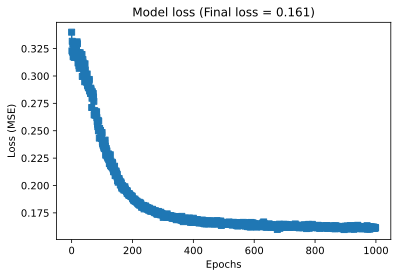

In [13]:
plt.plot(losses, 's-', label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title(f'Model loss (Final loss = {losses[-1]:.3f})')
plt.show()

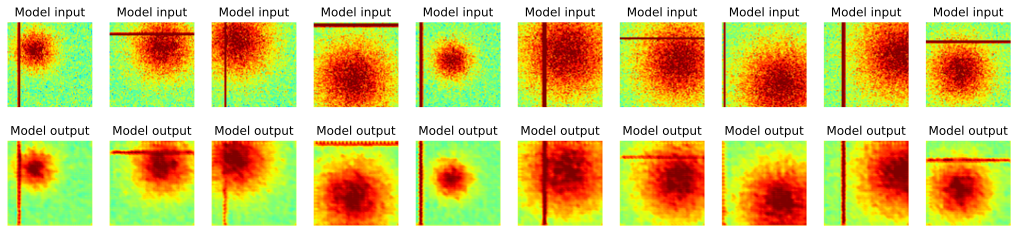

In [14]:
pics_2_use = np.random.choice(n_gauss, size=32, replace=False)
X          = images[pics_2_use, :, :, :]
# X          = images_occ[pics_2_use, :, :, :]
y_hat      = net(X)

fig, axs = plt.subplots(2, 10, figsize=(18, 4))
for i in range(10):
    G = torch.squeeze(X    [i, 0, :, :]).detach()
    O = torch.squeeze(y_hat[i, 0, :, :]).detach()
    
    axs[0, i].imshow(G, vmin=-1, vmax=1, cmap='jet')
    axs[0, i].axis('off')
    axs[0, i].set_title('Model input')
    
    axs[1, i].imshow(O, vmin=-1, vmax=1, cmap='jet')
    axs[1, i].axis('off')
    axs[1, i].set_title('Model output')

plt.show()

# Additional explorations

In [15]:
# 1) The code in this notebook requires "manually" switching between loss functions by (un)commenting. Modify the
#    code so that you can list the name of the loss function as an input to makeTheNet().
# 
# 2) Here's an interesting loss function: minimize the variance of the model's output. Don't worry about comparing
#    to the input image; just set the loss function to be the variance of the output. What do the results look like,
#    and why does this happen?
# 
# 3) What if L2 minimization (MSE) is more important than average minimization? Modify the L2LossAve class so that the
#    average has a weaker influence compared to the L2 loss.
# 
# 
# Reminder: This codeChallenge was designed to be a fun exercise to introduce you to the mechanics of creating and using
#           custom-built loss functions. The PyTorch built-in MSELoss is actually the best one to use for autoencoders
#           in most cases.
# 